<a href="https://colab.research.google.com/github/bereml/iap/blob/master/libretas/5a_auto_rot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje autosupervisado basado en rotaciones


Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---
En esta libreta implementaremos un ejemplo de aprendizaje autosupervisado donde la tarea pretexto consiste en aprender la rotación de la imagen de entrada del conjunto CIFAR-10. Este ejemplo se basa en el artículo [*Unsupervised Representation Learning by Predicting Image Rotations*](https://arxiv.org/abs/1803.07728) de Gidaris et al. El objetivo es estudiar el aprendizaje autosupervisado y su potencial beneficio en el entrenamiento.

![RotNet](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/rotnet.jpg)

# Explorando una tarea pretexto

En este ejemplo realizaremos clasificación del conjunto CIFAR-10. Contamos 3 subconjuntos: preentrenamiento con 50000 imágenes no etiquetadas, entrenamiento 5000 imágenes etiquetadas y prueba con 5000 imágenes etiquetadas

![auto](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/auto.png)

Se entrenaran dos clasificadores con el subconjunto de entrenamiento y se evaluaran en el subconjunto de prueba. Sin embargo, uno de estos clasificadores se preentrenará de forma autosupervisada para predecir la rotación de la imagen en el subconjunto de preentrenamiento

La siguiente tabla muestra los resultados de estos dos clasificadores y un clasificador entrenados empleando las 50k etiquetas del conjunto original.

| Entrenamiento        | Preentrenamiento | Entrenamiento | Prueba | Exactitud |
|----------------------|------------------|---------------|--------|-----------|
| Aleatorio            | NA               | NA            | NA     | 10.00     |
| Supervisado          | NA               | 5000          | 5000   | 54.25     |
| Auto+Super 2 Rot     | 50000            | 5000          | 5000   | 60.88     |
| Supervisado Completo | NA               | 50000         | 5000   | 68.50     |

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
import random
from copy import deepcopy
from itertools import islice as take
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from skimage import io
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from PIL import Image

### 1.2 Bibliotecas

In [2]:
DATA_DIR = '../datos'

# CIFAR-10
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)
LABELS = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)
ROTS = {0: 0, 1: 90, 2: 180, 3: 270}
BATCH_SIZE = 64


def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def display_batch(xs, titles, rows=3, cols=4, figsize=(6, 4)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    # convertimos a entero
    xs = (xs.numpy()).astype(np.uint8)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

def display_processed_batch(x, titles, rows=3, cols=4, figsize=(6, 4)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(MEAN, STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    display_batch(x, titles, rows, cols, figsize)

set_seed()

## 2 Datos

### 2.1 Exploración

Files already downloaded and verified
x shape=torch.Size([12, 32, 32, 3]) dtype=torch.uint8
y shape=torch.Size([12]) dtype=torch.int64


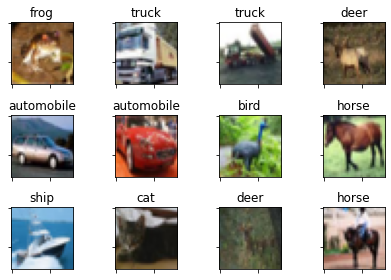

In [3]:
# creamos un Dataset
ds = CIFAR10(root=DATA_DIR, train=True, transform=np.array, download=True)
# creamos un DataLoader
dl = DataLoader(ds, batch_size=12)

# pedimos lote
x, y = next(iter(dl))
# desplegamos
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
labels = [LABELS[l] for l in y]
display_batch(x, labels)

### 2.2 Subconjunto de preentrenamiento autosupervisado

In [4]:
class CIFAR10With2Rot(CIFAR10):
    
    def random_rotate(self, x):
        r = randint(0, 4)
        if r in {0, 1}:
            return x, 0
        else:
            return np.flipud(np.fliplr(x)), 2
    
    def __getitem__(self, index):
        # leemos la imagen
        img = self.data[index]
        # la rotamos
        img, target = self.random_rotate(img)
        # la convertimos a pillow
        img = Image.fromarray(img)
        # aplicamos transformación si es necesario
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target

In [5]:
tsfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
pre_ds2 = CIFAR10With2Rot(root=DATA_DIR, train=True, transform=tsfm)
print(len(pre_ds2))

50000


x shape=torch.Size([64, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([64]) dtype=torch.int64
tensor([2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0,
        0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2,
        0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0])


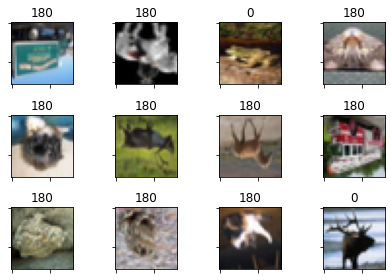

In [6]:
# creamos un DataLoader
pre_dl2 = DataLoader(pre_ds2, batch_size=BATCH_SIZE, shuffle=True)

# pedimos lote
x, y = next(iter(pre_dl2))
# desplegamos
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
print(y)
labels = [ROTS[l.item()] for l in y]
display_processed_batch(x, labels)

### 2.3 Subconjuntos de entrenamiento y prueba

In [7]:
class MiniCIFAR10(CIFAR10):
    
    def __init__(self, root, train, transform, download=False, train_size=5000):
        super(MiniCIFAR10, self).__init__(root=root, 
                                          train=False, 
                                          transform=transform, 
                                          download=download)
        if train:
            self.data = self.data[:train_size]
            self.targets = self.targets[:train_size]
        else:
            self.data = self.data[train_size:]
            self.targets = self.targets[train_size:]

#### Entrenamiento

In [8]:
trn_ds = MiniCIFAR10(root=DATA_DIR, train=True, transform=tsfm)
print(len(trn_ds))

5000


x shape=torch.Size([64, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([64]) dtype=torch.int64


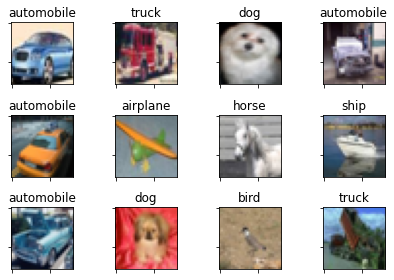

In [9]:
# creamos un DataLoader
trn_dl = DataLoader(trn_ds, batch_size=BATCH_SIZE, shuffle=True)

# pedimos lote
x, y = next(iter(trn_dl))
# desplegamos
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
labels = [LABELS[l] for l in y]
display_processed_batch(x, labels)

#### Prueba

In [10]:
tst_ds = MiniCIFAR10(root=DATA_DIR, train=False, transform=tsfm)
print(len(tst_ds))

5000


x shape=torch.Size([64, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([64]) dtype=torch.int64


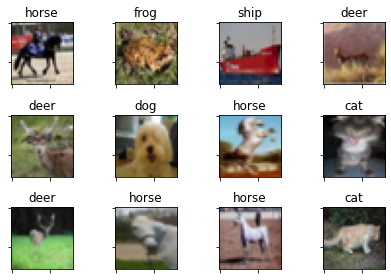

In [11]:
# creamos un DataLoader
tst_dl = DataLoader(tst_ds, batch_size=BATCH_SIZE, shuffle=False)

# pedimos lote
x, y = next(iter(tst_dl))
# desplegamos
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
labels = [LABELS[l] for l in y]
display_processed_batch(x, labels)

## 3 Modelo

In [12]:
class CNN(nn.Module):

    def __init__(self, num_classes):
        super(CNN, self).__init__()
        C1, C2, C3 = 8, 16, 32
        self.num_feats = 32 * 4 * 4
        self.cnn = nn.Sequential(
            # conv1
            # [N, 3, 32, 32] => [N, 8, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=C1, kernel_size=3, padding=1),
            # [N, 8, 32, 32]
            nn.ReLU(),
            # [N, 8, 32, 32] => [N, 8, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 8, 16, 16]
            nn.BatchNorm2d(C1),
            # conv2
            # [N, 8, 16, 16] => [N, 16, 16, 16]
            nn.Conv2d(in_channels=C1, out_channels=C2, kernel_size=3, padding=1),
            # [N, 16, 16, 16]
            nn.ReLU(),
            # [N, 16, 16, 16] => [N, 16, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 16, 8, 8]
            nn.BatchNorm2d(C2),
            # conv3
            # [N, 16, 8, 8] => [N, 32, 8, 8]
            nn.Conv2d(in_channels=C2, out_channels=C3, kernel_size=3, padding=1),
            # [N, 32, 16, 16]
            nn.ReLU(),
            # [N, 32, 8, 8] => [N, 32, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 32, 4, 4]
            nn.BatchNorm2d(C3)
        )
        # [N, 32, 4, 4] => [N, 32x4x4]
        self.flatten = nn.Flatten()
        # [N, 32x4x4] => [N, 4]
        self.cls = nn.Linear(self.num_feats, num_classes)

    def forward(self, x):
        # [N, 3, 32, 32] => [N, 16, 8, 8]
        x = self.cnn(x)
        # [N, 32, 4, 4] => [N, 32x4x4]
        x = self.flatten(x)
        # [N, 32x4x4] => [N, num_classes]
        x = self.cls(x)
        return x

In [13]:
model = CNN(10)
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {x.shape}')
print(model)

torch.Size([1, 3, 32, 32]) => torch.Size([1, 3, 32, 32])
CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten()
  (cls): Linear(in_features=512, out_features=10, bias=True)
)


## 4 Entrenamiento

In [14]:
def fit(model, trn_dl, tst_dl, epochs=15, lr=0.001, tst_batches=None):
    # dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # mejor exactitud
    best_acc = 0
    best_model = model

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # modelo en modo de entrenamiento
        model.train()
        
        # entrenamiento de una época
        for x, y_true in trn_dl:
            x = x.to(device)
            y_true = y_true.to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actualizamos parámetros
            opt.step()

        # evitamos que se registren las operaciones 
        # en la gráfica de cómputo
        with torch.no_grad(): 

            # modelo en modo de evaluación
            model.eval()

            losses, accs = [], []
            # validación de la época
            for x, y_true in take(tst_dl, tst_batches):
                x = x.to(device)
                y_true = y_true.to(device)
                
                # hacemos inferencia para obtener los logits
                y_lgts = model(x)

                # calculamos las probabilidades
                y_prob = F.softmax(y_lgts, 1)
                # obtenemos la clase predicha
                y_pred = torch.argmax(y_prob, 1)

                # calculamos la pérdida
                loss = F.cross_entropy(y_lgts, y_true)
                # calculamos la exactitud
                acc = (y_true == y_pred).type(torch.float32).mean()

                # guardamos en históricos
                losses.append(loss.item())
                accs.append(acc.item())

            # imprimimos métricas
            loss = np.mean(losses) * 100
            acc = np.mean(accs) * 100
            print(f'E{epoch:2} loss={loss:6.2f} acc={acc:5.2f}')
            
            if acc > best_acc: 
                best_acc = acc
                best_model = deepcopy(model)

            # modelo en modo de entrenamiento
            model.train()

    print(f'\nMejor exactitud {best_acc:5.2f}')
    return best_model

![auto](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/auto.png)

### 4.1 Entrenamiento supervisado

In [15]:
import torchvision.models as tvm
set_seed()
model1 = CNN(10)
model1.fc = nn.Linear(1024, 10)
_ = fit(model1, trn_dl, tst_dl)

E 0 loss=154.64 acc=43.41
E 1 loss=139.81 acc=49.58
E 2 loss=138.63 acc=50.65
E 3 loss=133.00 acc=52.33
E 4 loss=133.35 acc=52.16
E 5 loss=132.39 acc=53.12
E 6 loss=134.88 acc=52.95
E 7 loss=138.10 acc=51.92
E 8 loss=139.31 acc=53.38
E 9 loss=140.90 acc=52.81
E10 loss=141.56 acc=53.01
E11 loss=146.93 acc=52.08
E12 loss=151.70 acc=51.15
E13 loss=154.80 acc=51.54
E14 loss=159.36 acc=51.33

Mejor exactitud 53.38


### 4.2 Entrenamiento autosupervisado con 2 rotaciones + supervisado

In [16]:
# preentrenamos con autosupervisión
set_seed()
model2 = CNN(4)
model2.fc = nn.Linear(1024, 4)
model2 = fit(model2, pre_dl2, pre_dl2, tst_batches=5)

E 0 loss= 46.13 acc=77.50
E 1 loss= 38.30 acc=80.31
E 2 loss= 39.61 acc=80.00
E 3 loss= 37.14 acc=82.50
E 4 loss= 44.29 acc=78.12
E 5 loss= 37.94 acc=82.81
E 6 loss= 37.31 acc=83.12
E 7 loss= 40.53 acc=81.88
E 8 loss= 33.32 acc=84.06
E 9 loss= 29.78 acc=89.69
E10 loss= 41.74 acc=81.56
E11 loss= 34.66 acc=85.62
E12 loss= 38.82 acc=82.50
E13 loss= 33.56 acc=87.19
E14 loss= 34.88 acc=82.19

Mejor exactitud 89.69


In [17]:
# trasferencia de conocimiento
# reusamos las conv y remplazamos la capa fc
set_seed()
model2.cls = nn.Linear(model2.num_feats, 10)
# entrenamos el modelo
_ = fit(model2, trn_dl, tst_dl)

E 0 loss=139.95 acc=49.98
E 1 loss=128.94 acc=53.82
E 2 loss=124.08 acc=55.16
E 3 loss=118.73 acc=58.62
E 4 loss=117.82 acc=58.01
E 5 loss=116.28 acc=59.26
E 6 loss=121.19 acc=58.33
E 7 loss=117.77 acc=59.00
E 8 loss=120.43 acc=59.24
E 9 loss=120.44 acc=59.16
E10 loss=121.89 acc=58.68
E11 loss=122.71 acc=59.10
E12 loss=126.62 acc=59.08
E13 loss=129.20 acc=58.39
E14 loss=134.51 acc=58.15

Mejor exactitud 59.26


## 5 Participación: entrenamiento autosupervisado con 4 rotaciones

Entrena un modelo con un preentrenamiento autosupervisado considerando 4 rotaciones (0, 90, 180, 270) y compara los resultados. Para implementar las rotaciones puedes usar:
  * `np.flipud(np.transpose(x, (1, 0, 2)))` para 90,
  * `np.fliplr(np.transpose(x, (1, 0, 2)))` para 270.

#### Subconjunto con 4 rotaciones

#### Preentranmiento autosupervisado

#### Transferencia y afinado